In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import scIB
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
default_fig_size = (8,8)
plt.rcParams['figure.figsize'] = default_fig_size

In [3]:
adata_file = "/storage/groups/ml01/workspace/group.daniela/MCA_normalised/Mammary.h5ad"
adata_file = "/storage/groups/ml01/workspace/group.daniela/tm/facs/norm/Thymus_raw.h5ad"
adata = sc.read(adata_file, cache=True)

In [4]:
adata

AnnData object with n_obs × n_vars = 1349 × 23433 
    obs: 'tissue', 'sample', 'sex', 'cell_type', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'size_factors'
    layers: 'counts'

Computed 4000 highly variable genes
PCA
Nearest Neigbours
UMAP


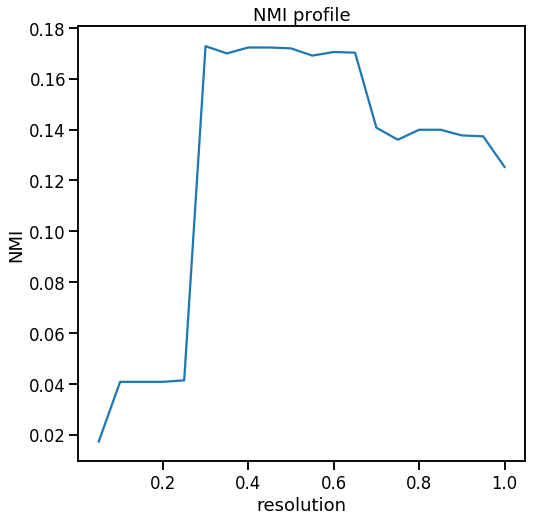

In [5]:
scIB.preprocessing.reduce_data(adata, hvg=True, batch_key='tissue', pca=True, umap=True)
opt_clus = scIB.clustering.opt_louvain(adata, label='cell_type', plot=True)

In [6]:
opt_clus[0:2]

(0.3, 0.17279237433777006)

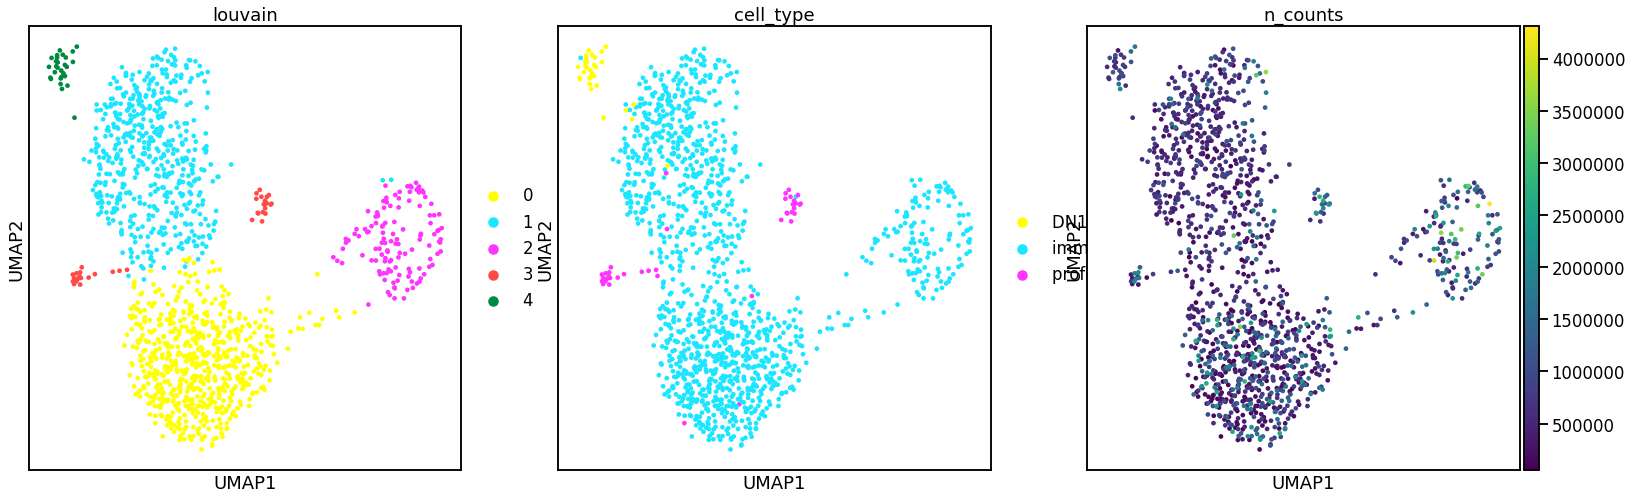

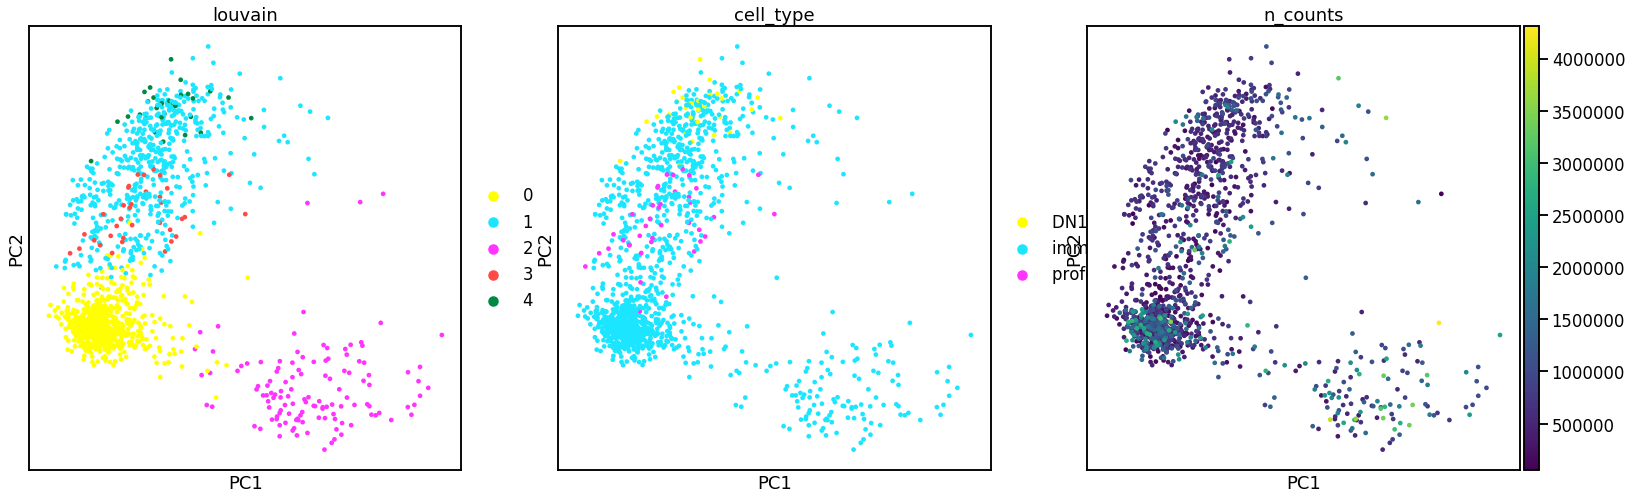

In [7]:
sc.pl.umap(adata, color=['louvain', 'cell_type', 'n_counts'], palette=sc.pl.palettes.godsnot_64)
sc.pl.pca(adata, color=['louvain', 'cell_type', 'n_counts'], palette=sc.pl.palettes.godsnot_64)

## Integrated Data

In [8]:
integrated = pickle.load(open(data_dir+'processed/integrated_dict.h5ad', "rb"))

NameError: name 'data_dir' is not defined

## Silhouette score

In [8]:
sil = scIB.metrics.silhouette_score(adata, batch_key='sample', group_key='cell_type', verbose=False)

In [9]:
sil.head()

,group,silhouette_score
0,DN1 thymic pro-T cell,0.089117
1,DN1 thymic pro-T cell,0.054605
2,DN1 thymic pro-T cell,0.119795
3,DN1 thymic pro-T cell,0.000000
4,DN1 thymic pro-T cell,0.199306


mean silhouette per cell:        silhouette_score
group                  
0              0.033530
1              0.082013
2              0.041107
3              0.133055
4              0.103523


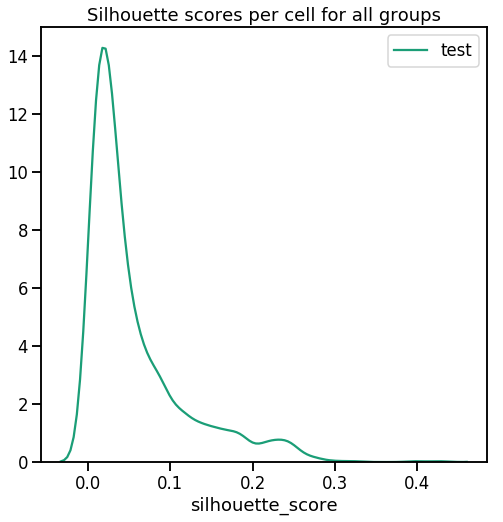


mean silhouette per cell:        silhouette_score
group                  
0              0.033530
1              0.082013
2              0.041107
3              0.133055
4              0.103523


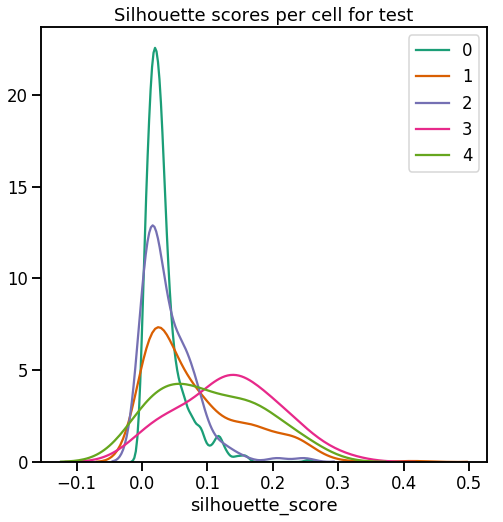

In [8]:
scIB.metrics.plot_silhouette_score({'test' : adata}, 
                                   batch_key='sample', group_key='louvain',
                                   per_group=True)

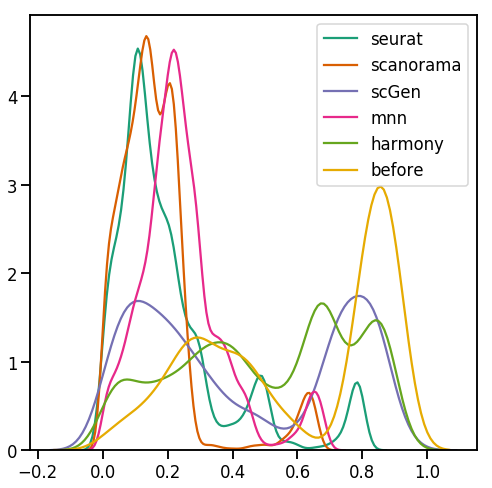

In [4]:
scIB.metrics.plot_silhouette_score(integrated, verbose=False)

## Simple Cluster overlap

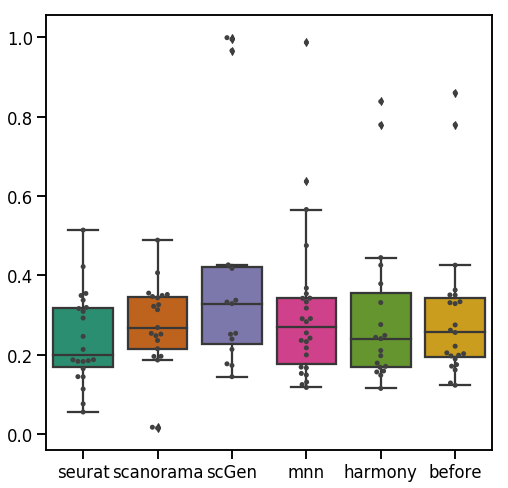

In [5]:
scIB.metrics.plot_cluster_overlap(integrated, group1='louvain', group2='louvain_post', df=False)

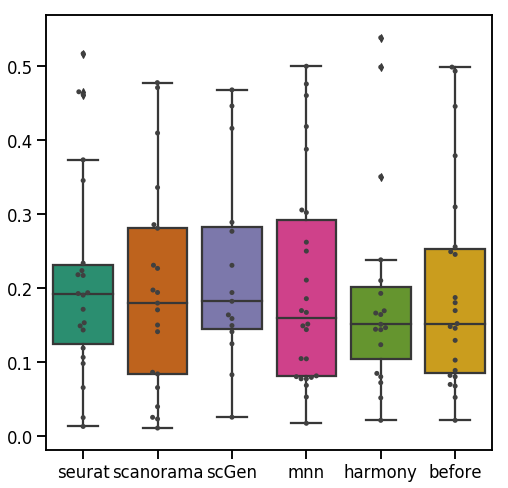

In [6]:
scIB.metrics.plot_cluster_overlap(integrated, group1='cell_ontology_class', group2='louvain_post', df=False)

## NMI Normalized mutual information

### Time comparison

Scikit-learn with `average_method='max'`

In [9]:
%timeit for x in range(100): scIB.metrics.nmi(adata, group1='cell_type', group2='louvain')

8.88 s ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
scIB.metrics.nmi(adata, group1='cell_type', group2='louvain')

0.4693874266278376

Lancichinetti 2009

In [10]:
%timeit for x in range(100): scIB.metrics.nmi(adata, group1='cell_type', group2='louvain', method='Lancichinetti', nmi_dir='../../../mutual3/')

29.7 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
scIB.metrics.nmi(adata, group1='cell_type', group2='louvain', method='Lancichinetti', nmi_dir='../../../mutual3/')

0.096854

Overlap NMI 2011

In [11]:
%timeit for x in range(100): scIB.metrics.nmi(adata, group1='cell_type', group2='louvain', method='ONMI', nmi_dir='../../../Overlapping-NMI/')

../../../Overlapping-NMI/onmi: error while loading shared libraries: libgsl.so.23: cannot open shared object file: No such file or directory



IndexError: list index out of range

## ARI Adjusted rand index

In [12]:
scIB.metrics.ari(adata, group1='cell_type', group2='louvain')

0.3749636053615194

## PC Regression

In [9]:
scIB.metrics.pc_regression(
    adata.obsm['X_pca'], 
    adata.obs['n_counts'], 
    pca_sd=adata.uns['pca']['variance']
)

PC regression


0.06204410382182554

In [10]:
scIB.metrics.pc_regression(adata.X, adata.obs['n_counts'])

PCA
PC regression


0.04983906561952651

In [27]:
import numpy as np
from scipy import sparse
import anndata
import pandas as pd
def pc_regression(data, batch, pca_sd=None, n_comps=None, svd_solver='arpack', verbose=True):
    """
    params:
        data: Anndata or count matrix
        batch: series or list of batch assignemnts
        n_comps: number of PCA components, only when PCA is not yet computed
        pca_sd: iterable of variances for `n_comps` components. If `pca_sd` is not `None`, it is assumed that the matrix contains PCA values, else PCA is computed
    """
    
    if isinstance(data, anndata.AnnData):
        matrix = adata.X
        pca_sd = None
    elif isinstance(data, (np.matrix, np.ndarray, sparse.csr_matrix)):
        matrix = data
    else:
        raise TypeError(f'invalid type {data.__class__} for data')
    
    # perform PCA if necessary
    if pca_sd is None:
        if verbose:
            print("PCA")
            
        if n_comps is None or n_comps > min(matrix.shape):
            n_comps = min(matrix.shape)

        if n_comps == min(matrix.shape):
            svd_solver = 'full'
    
        pca = sc.tl.pca(matrix,
                        n_comps=n_comps,
                        use_highly_variable=False,
                        return_info=True,
                        svd_solver=svd_solver,
                        copy=True)
        X_pca = pca[0].copy()
        pca_sd = pca[3].copy()
        del pca
    else:
        X_pca = matrix
        n_comps = matrix.shape[1]
    
    ## PC Regression
    if verbose:
        print("PC regression")    
                
    batch = pd.get_dummies(batch) if 'category' == str(batch.dtype) else np.array(batch)
    print(batch[1:10])
    
    # fit linear model for n_comps PCs
    if True:
        print("sklearn")
        from sklearn.linear_model import LinearRegression
        r2 = []
        for i in range(n_comps):
            lm = LinearRegression()
            lm.fit(X_pca[:, [i]], batch)
            r2.append(lm.score(X_pca[:, [i]], batch))
    else:
        print('statsmodels')
        import statsmodels as sm
        if sparse.issparse(X_pca):
            X_pca = X_pca.todense()
        r2 = []
        pvals = [] # t-test pvalues
        
        X_pca = sm.api.add_constant(X_pca) # add bias
        for i in range(1, n_comps+1): # i=0 is bias
            lm = sm.api.OLS(batch, X_pca[:, [0,i]]).fit()
            pvals.append(lm.pvalues[1])
            r2.append(lm.rsquared)
        # select significant fit: sig = BH-Pval < 0.05
        signif = sm.stats.multitest.multipletests(pvals, alpha=0.05, method='fdr_bh')[0]
        #pcRegscale = sum(Var[signif])/sum(Var)
    
    Var = pca_sd**2 / sum(pca_sd**2) * 100
    R2Var = sum(r2*Var)/100
    return R2Var

In [31]:
pc_regression(adata.obsm['X_pca'], adata.obs['cell_type'], pca_sd=adata.uns['pca']['variance'])

PC regression
cell_type                DN1 thymic pro-T cell  immature T cell  \
index                                                             
I8.MAA000607.3_9_M.1.1                       0                1   
J10.MAA000607.3_9_M.1.1                      0                1   
K12.MAA000607.3_9_M.1.1                      0                1   
A17.MAA000607.3_9_M.1.1                      0                1   
A16.MAA000607.3_9_M.1.1                      0                1   
B18.MAA000607.3_9_M.1.1                      0                1   
D22.MAA000607.3_9_M.1.1                      0                1   
F2.MAA000607.3_9_M.1.1                       0                1   
G4.MAA000607.3_9_M.1.1                       0                1   

cell_type                professional antigen presenting cell  
index                                                          
I8.MAA000607.3_9_M.1.1                                      0  
J10.MAA000607.3_9_M.1.1                                 

0.016560207498557758

In [29]:
pc_regression(adata.obsm['X_pca'], adata.obs['n_counts'], pca_sd=adata.uns['pca']['variance'])

PC regression
[ 144383. 1164289.  334512.  163142.  185919.  200105.  136243.  349665.
  167132.]
sklearn


0.06204410382182554

In [30]:
pc_regression(adata.X, adata.obs['cell_type'])

PCA
PC regression
cell_type                DN1 thymic pro-T cell  immature T cell  \
index                                                             
I8.MAA000607.3_9_M.1.1                       0                1   
J10.MAA000607.3_9_M.1.1                      0                1   
K12.MAA000607.3_9_M.1.1                      0                1   
A17.MAA000607.3_9_M.1.1                      0                1   
A16.MAA000607.3_9_M.1.1                      0                1   
B18.MAA000607.3_9_M.1.1                      0                1   
D22.MAA000607.3_9_M.1.1                      0                1   
F2.MAA000607.3_9_M.1.1                       0                1   
G4.MAA000607.3_9_M.1.1                       0                1   

cell_type                professional antigen presenting cell  
index                                                          
I8.MAA000607.3_9_M.1.1                                      0  
J10.MAA000607.3_9_M.1.1                             

0.013505357257220978

In [15]:
adata.obsm['X_pca'].shape

(1349, 50)

In [22]:
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR) # Ignore R warning messages
import rpy2.robjects as ro
import anndata2ri
def pc_regression_old(data, batch, pca_sd=None, n_comps=None, svd_solver='arpack', verbose=True):
    
    if isinstance(data, anndata.AnnData):
        matrix = adata.X
        pca_sd = None
    elif isinstance(data, (np.matrix, np.ndarray, sparse.csr_matrix)):
        matrix = data
    else:
        raise TypeError(f'invalid type {data.__class__} for data')
    
    # perform PCA if necessary
    if pca_sd is None:
        if verbose:
            print("PCA")
            
        if n_comps is None:
            n_comps = min(matrix.shape)

        if n_comps == min(matrix.shape):
            svd_solver = 'full'
    
        pca = sc.tl.pca(matrix,
                        n_comps=n_comps,
                        use_highly_variable=False,
                        return_info=True,
                        svd_solver=svd_solver,
                        copy=True)
        X_pca = pca[0].copy()
        pca_sd = pca[3].copy()
        del pca
    else:
        X_pca = matrix
        
    # Activate R
    anndata2ri.activate()
    ro.r("library(kBET)")
    
    if verbose:
        print("importing data to R")
    ro.globalenv['batch'] = batch
    ro.globalenv["X_pca"] = X_pca
    ro.globalenv["pca_stdev"] = pca_sd
    ro.r("pca.data <- list(x=X_pca, sdev=pca_stdev)")
    
    if verbose:
        print("PC regression")
    pcr = ro.r("batch.pca <- pcRegression(pca.data, batch, n_top=50)")

    anndata2ri.deactivate()    
    return dict(zip(pcr.names, list(pcr)))

In [25]:
pc_regression_old(adata.X, adata.obs['cell_type'])#, n_comps=50)
#print(np.array(pcr['r2'][0:50]))
#pcr['R2Var']

PCA
importing data to R
PC regression


{'maxVar': R object with classes: ('array',) mapped to:
 [17.400000, 0.800000, 0.200000, 0.100000, 0.100000],
 'PmaxVar': R object with classes: ('numeric',) mapped to:
 [0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
 'pcNfrac': R object with classes: ('numeric',) mapped to:
 [0.240000],
 'pcRegscale': R object with classes: ('numeric',) mapped to:
 [0.961722],
 'maxCorr': R object with classes: ('numeric',) mapped to:
 [0.536847],
 'maxR2': R object with classes: ('numeric',) mapped to:
 [0.288204],
 'msigPC': R object with classes: ('numeric',) mapped to:
 [1.000000],
 'maxsigPC': R object with classes: ('numeric',) mapped to:
 [0.920000],
 'R2Var': R object with classes: ('numeric',) mapped to:
 [0.022281],
 'ExplainedVar': R object with classes: ('array',) mapped to:
 [60.400000, 17.400000, 1.200000, 0.800000, ..., 0.000000, 0.000000, 0.000000, 0.000000],
 'r2': R object with classes: ('matrix',) mapped to:
 [0.006105, 0.072698, 0.087034, 0.175894, ..., 0.021534, 0.706078, 0.9

In [26]:
pc_regression(adata.X, adata.obs['cell_type'])

PCA
PC regression
sklearn


0.013505357257220978

In [81]:
pcr = pc_regression_old(adata.obsm['X_pca'], adata.obs['n_counts'], pca_sd=adata.uns['pca']['variance'])

importing data to R
PC regression
[1] 50  3


In [82]:
pcr['R2Var']

0.062067


In [83]:
np.array(pcr['r2'][0:50])

array([9.04316101e-02, 2.61799599e-02, 2.26685109e-03, 3.32051525e-03,
       9.44300947e-03, 1.65894921e-03, 1.12640781e-02, 7.03689496e-03,
       3.02576244e-03, 3.03707377e-04, 3.25350683e-03, 1.28293142e-02,
       2.20387096e-03, 1.49838884e-02, 4.11581454e-03, 1.07858529e-02,
       1.29756023e-03, 4.46936692e-03, 1.41581133e-02, 1.07266655e-03,
       4.82639627e-03, 8.10414113e-03, 1.03716237e-03, 7.50404419e-05,
       2.13205362e-05, 3.84494866e-03, 1.05610443e-03, 7.03195150e-04,
       1.29231171e-03, 6.38696325e-03, 1.79075396e-03, 1.05361429e-05,
       4.54693123e-07, 2.64827606e-03, 2.50308190e-03, 1.20429252e-03,
       1.61609432e-05, 1.39105118e-03, 1.43734252e-04, 6.40321625e-05,
       2.22712983e-04, 1.24410820e-03, 5.89334815e-04, 1.01963901e-03,
       1.57707932e-06, 5.43664762e-05, 1.35128860e-03, 2.22092900e-04,
       3.09675368e-04, 2.60395643e-03])

In [84]:
pc_regression(adata.obsm['X_pca'], adata.obs['n_counts'], pca_sd=adata.uns['pca']['variance'])

PC regression
sklearn
[0.09043163308305702, 0.026179975089076102, 0.002266869819045003, 0.0033205349350390323, 0.009443025860827015, 0.0016589750461973864, 0.011264094942913805, 0.007036917942361498, 0.0030257948526725142, 0.00030373302850028594, 0.003253529309194536, 0.012829335537776654, 0.00220389144506572, 0.01498391456785364, 0.004115842860706209, 0.010785871528350643, 0.0012975864267791293, 0.004469390751973057, 0.014158134717779046, 0.0010726809779972868, 0.004826418044879044, 0.008104166999077234, 0.0010371823743399178, 7.50584417312794e-05, 2.1335478252892948e-05, 0.0038449701603854303, 0.0010561323499357345, 0.0007032206481912828, 0.0012923343230338835, 0.006386987101636876, 0.0017907785320560032, 1.0558175238095657e-05, 4.842441693186927e-07, 0.002648292249996631, 0.002503112177596356, 0.0012043140972457511, 1.6179629969581555e-05, 0.0013910759262946162, 0.00014375680374001387, 6.405590308478093e-05, 0.00022273969883868094, 0.0012441320425872204, 0.0005893596508289578, 0.001

0.06204410382182554